# Credit Assignment Problem

Goal: Visualize how assigning credit to past actions improves learning

We’ll write two versions:

	1.	Naive Policy Gradient (no credit assignment — treats all rewards the same)

	2.	Proper Policy Gradient (with discounted rewards and advantage normalization)

In [1]:
import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#Policy Network

class PolicyNet(nn.Module):
    def __init__(self, obs_dim, hidden_dim, n_actions):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, n_actions),
            nn.Softmax(dim=-1)
        )
    
    def forward(self, x):
        return self.net(x)

In [3]:
# Discounted Return Calculator

def compute_discounted_returns(rewards, gamma):
    G = 0
    returns = []

    for r in reversed(rewards):
        G = r + gamma * G
        returns.insert(0, G)

    returns = torch.tensor(returns, dtype=torch.float32)

    return returns

In [4]:
# Naive version (No credit Assignment)

def train_naive_policy(policy, env, episodes, gamma):
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    rewards_history = []

    for episode in range(episodes):
        obs, _ = env.reset()
        log_probs = []
        rewards = []

        for _ in range(200):
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            probs = policy(obs_tensor)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            obs,reward,terminated,truncated, _ = env.step(action.item())
            rewards.append(reward)

            if terminated or truncated:
                break
        
        # Naive: Use total reward for all time steps
        total_return = sum(rewards)
        loss = -sum(log_probs) * total_return

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rewards_history.append(total_return)
    
    return rewards_history

In [5]:
# With Credit assignment

def train_credit_assigned_policy(policy, env,episodes, gamma):
    optimizer = optim.Adam(policy.parameters(), lr=0.01)
    rewards_history = []

    for episode in range(episodes):
        obs, _ = env.reset()
        log_probs = []
        rewards = []

        for _ in range(200):
            obs_tensor = torch.tensor(obs, dtype=torch.float32)
            probs = policy(obs_tensor)
            dist = torch.distributions.Categorical(probs)
            action = dist.sample()
            log_probs.append(dist.log_prob(action))
            obs, reward, terminated, truncated, _ = env.step(action.item())

            rewards.append(reward)
            if terminated or truncated:
                break
        
        returns = compute_discounted_returns(rewards, gamma)
        # normalize returns(adavantage-like)

        returns = (returns - returns.mean()) / (returns.std() + 1e-9)

        loss = -sum(log_prob * G for log_prob, G in zip(log_probs, returns))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        rewards_history.append(sum(rewards))

    return rewards_history

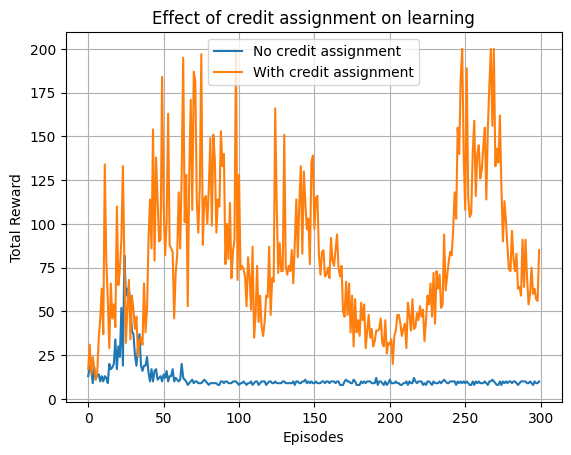

In [6]:
env = gym.make('CartPole-v1')

episodes = 300
gamma = 0.99

naive_policy = PolicyNet(4, 128, 2)
credit_policy = PolicyNet(4, 128, 2)

naive_rewards = train_naive_policy(naive_policy, env, episodes, gamma)
credit_rewards = train_credit_assigned_policy(credit_policy, env, episodes, gamma)

plt.plot(naive_rewards, label='No credit assignment')
plt.plot(credit_rewards, label='With credit assignment')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Effect of credit assignment on learning')
plt.legend()
plt.grid(True)
plt.show()

What You’re Seeing in the Plot

Blue Line: No Credit Assignment

	•	Every action in the episode is given equal blame/credit, regardless of when the reward came.
	•	Result: The learning is noisy and flatlines quickly.
	•	Agent fails to learn meaningful behavior because it doesn’t know which actions caused rewards.

Orange Line: With Credit Assignment

	•	Actions are rewarded based on their proximity to the final reward using:

	•	 Discounted returns: rewards closer in time to the action are weighted more.
	•	Normalization: makes gradients stable and training smoother.
	•	Result: Reward increases steadily and spikes toward the maximum (200).
	•	Agent learns much better because it can assign “credit” to earlier actions that led to later success.

 Credit Assignment Problem

In reinforcement learning, rewards are often delayed. It’s difficult for an agent to figure out which actions were actually responsible for the outcome.

	•	Problem: How to assign credit for a reward that comes much later?
	•	Symptoms: The agent fails to improve despite repeated episodes.
	•	Example: Balancing a pole — the final fall happens due to many subtle earlier mistakes.